# Generative AI project about Data Augmentation
> *This is the notebook for the ninth Profession AI project about Generative AI module*

## Setup & Configuration

In [1]:
!git clone https://github.com/Silvano315/Gen-AI-for-Data-Augmentation.git

Cloning into 'Gen-AI-for-Data-Augmentation'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 139 (delta 71), reused 96 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 7.00 MiB | 7.89 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
import os
os.chdir('/content/Gen-AI-for-Data-Augmentation')

In [3]:
!pwd

/content/Gen-AI-for-Data-Augmentation


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [6]:
!pip install clean-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [7]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/pip-req-build-z4ddnhpb
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/pip-req-build-z4ddnhpb
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369514 sha256=a2f643af069d8b1cfbd1410445e096058009b2ae665417a5e596fe7daedf705e
  Stored in directory: /private/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/pip-ephem-wheel-cache-xgum3iig/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 0.2.0
    Uninstalling clip-0.2.0:
      Successfully u

In [1]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
import torch
import json
from torch.utils.data import DataLoader
from torchvision import transforms
from src.data.dataset import PetDatasetHandler
from src.captioning.caption_generator import CaptionGenerator
from src.data.data_with_captions import PetDatasetWithCaptions
from src.utils.logging import GANLogger
from src.generation.image_generator import GANConfig, ConditionalGAN
from src.training.callbacks import EarlyStopping, ModelCheckpoint, MetricsHistory
from src.evaluation.metrics import FIDScore, CLIPScore, MetricsTracker
from src.training.training import GANTrainer

/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/Gen-AI-for-Data-Augmentation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize and load dataset without transforms for analysis

In [7]:
data_dir = Path('./data')
handler = PetDatasetHandler(data_dir)
train_dataset, test_dataset = handler.load_dataset()

### Basic dataset information

In [ ]:
info = handler.get_dataset_info()
print("Dataset Information:")
for key, value in info.items():
    print(f"{key}: {value}")

Dataset Information:
total_samples: 7349
train_samples: 3680
test_samples: 3669
num_classes: 37


### Plot distributions and samples

In [ ]:
handler.plot_class_distribution().show()

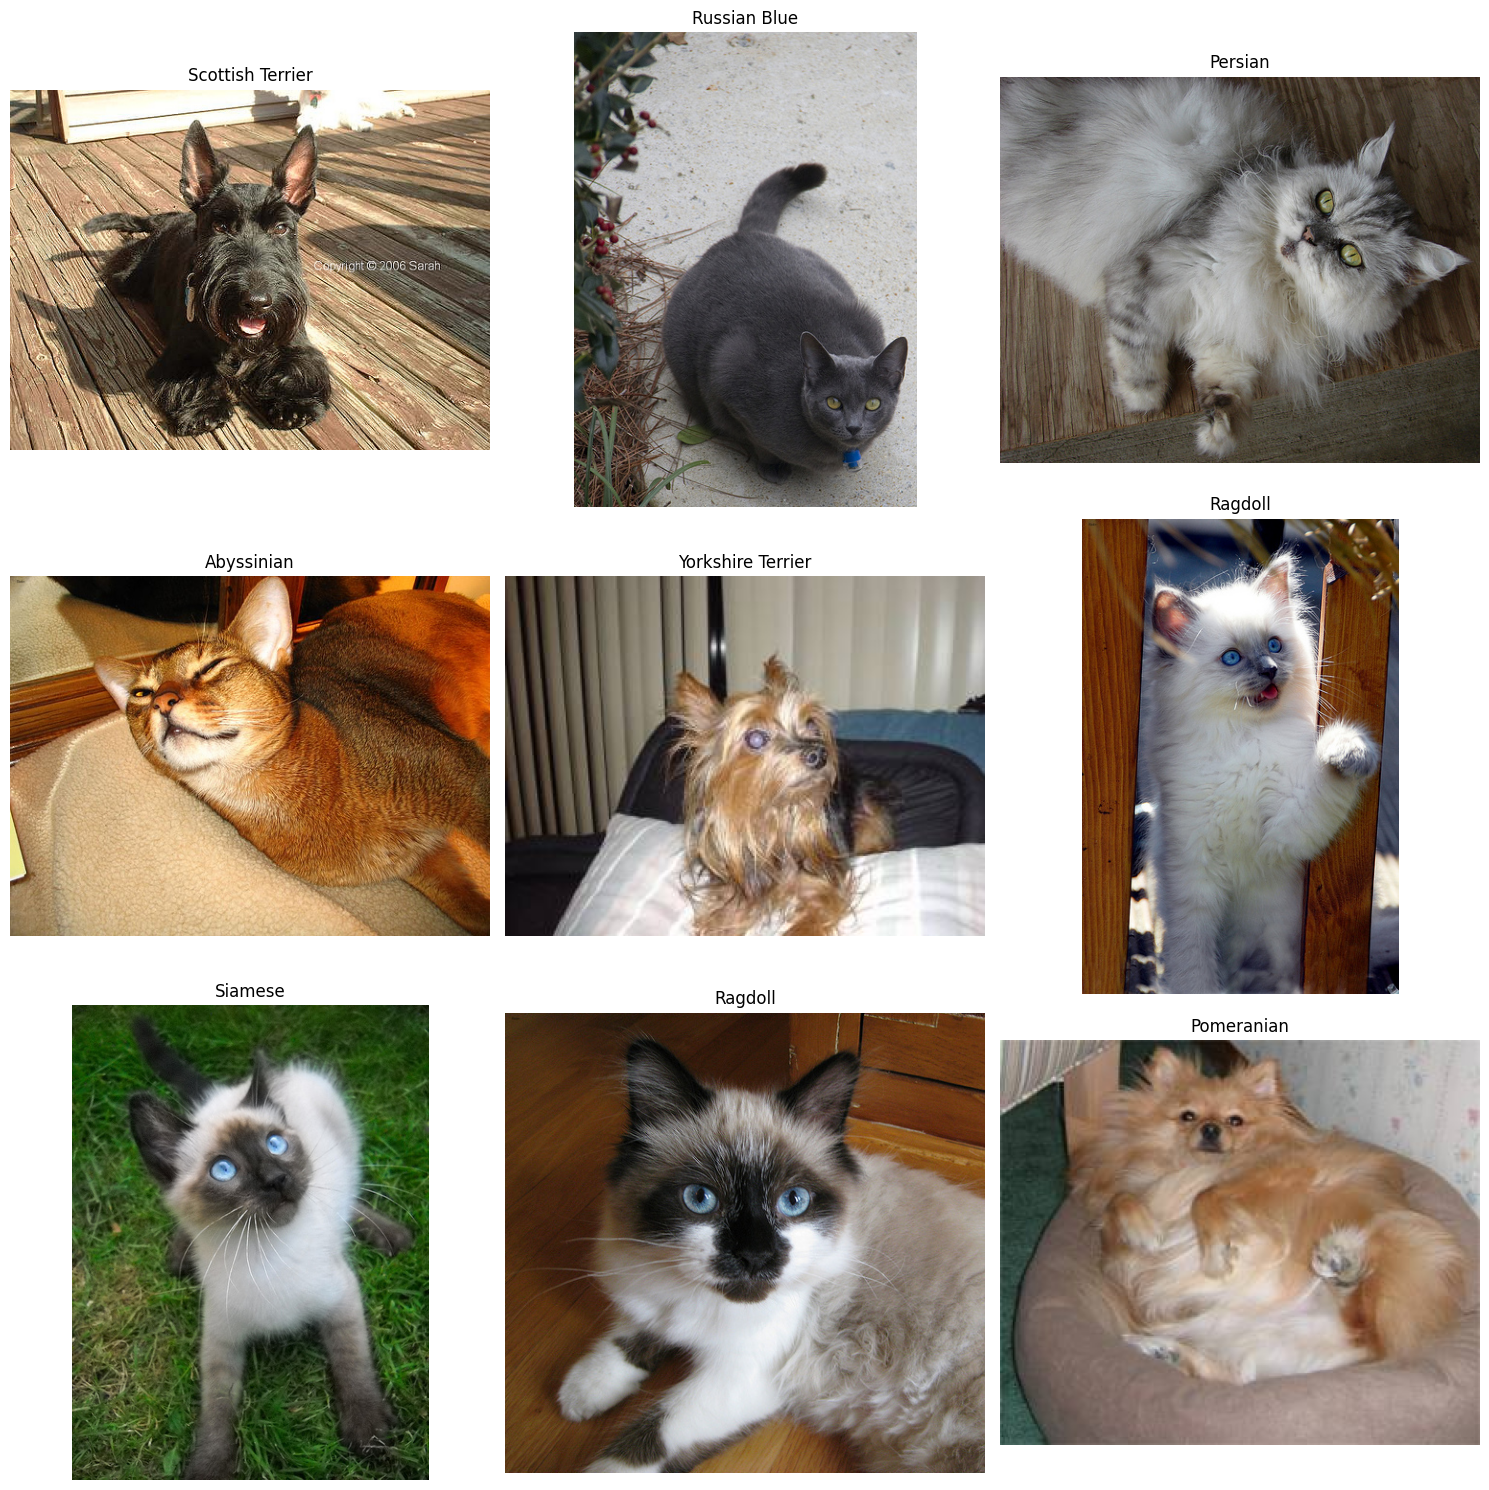

In [ ]:
handler.visualize_samples(9).show()

### Get detailed image statistics


In [ ]:
stats = handler.get_image_stats(sample_size=100)
print("\nImage Statistics:")
for category, values in stats.items():
    print(f"\n{category.upper()}:")
    for key, value in values.items():
        print(f"{key}: {value:.2f}")


Image Statistics:

DIMENSIONS:
mean_width: 436.57
mean_height: 406.11
std_width: 175.18
std_height: 239.36
min_width: 184.00
max_width: 1886.00
min_height: 145.00
max_height: 2606.00

ASPECT_RATIO:
mean: 1.15
std: 0.35


### For training, load with transforms

In [ ]:
train_transforms = handler.get_training_transforms()
train_dataset, test_dataset = handler.load_dataset(transform=train_transforms)

## Image Captioning

### Initialize caption generator

In [5]:
caption_gen = CaptionGenerator()

### Test single image caption generation

In [8]:
sample = random.randint(0, len(train_dataset)-1)
sample_image_path = Path(train_dataset._images[sample])
label = train_dataset.classes[train_dataset[sample][1]]
caption = caption_gen.generate_caption(sample_image_path, label, max_length = 50)
print(f"Sample caption: {caption}")

Sample caption: the cat is looking at the camera - This is a British Shorthair.


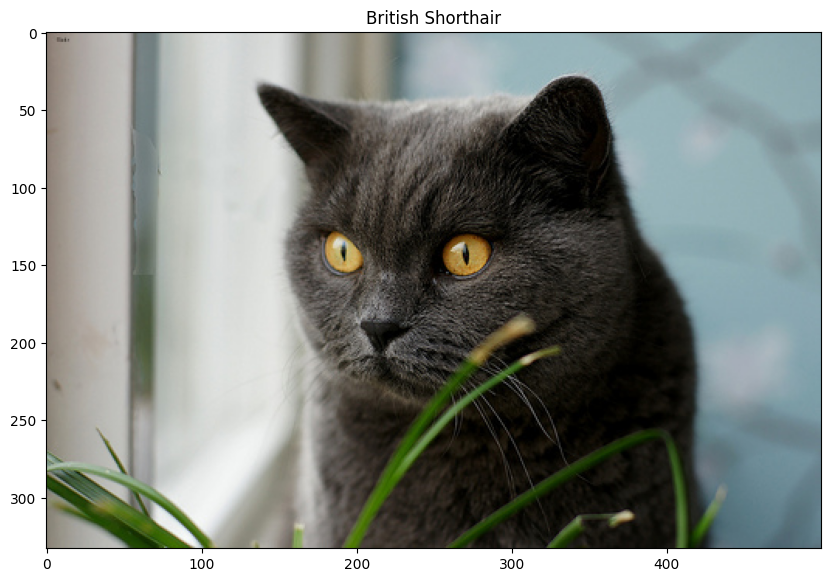

In [9]:
plt.figure(figsize=(10, 10))
plt.title(f"{label}")
fig = plt.imshow(train_dataset[sample][0])

### Process a batch of images


In [ ]:
batch_size = 4
image_paths = [Path(img) for img in train_dataset._images[:10]]
labels = [train_dataset.classes[train_dataset[i][1]] for i in range(10)]
captions = caption_gen.process_batch(image_paths, labels, batch_size=batch_size)

Processing batches: 100%|██████████| 3/3 [02:55<00:00, 58.39s/it]


### Process train and test datasets

In [18]:
batch_size = 4
image_paths = [Path(img) for img in test_dataset._images]
labels = [test_dataset.classes[test_dataset[i][1]] for i in range(len(image_paths))]

In [21]:
captions = caption_gen.process_batch(image_paths, labels, batch_size=batch_size)

caption_gen.save_captions(save_dir / 'captions_testdataset.json')

Processing batches: 100%|██████████| 918/918 [21:47<00:00,  1.42s/it]


### Save & Load captions


In [17]:
save_dir = Path('/content/drive/MyDrive/outputs_master_ProfAI/captions')
save_dir.mkdir(parents=True, exist_ok=True)
caption_gen.save_captions(save_dir / 'captions_testdataset.json')

In [ ]:
caption_gen.load_captions(save_dir / 'captions.json')

### Visualize results

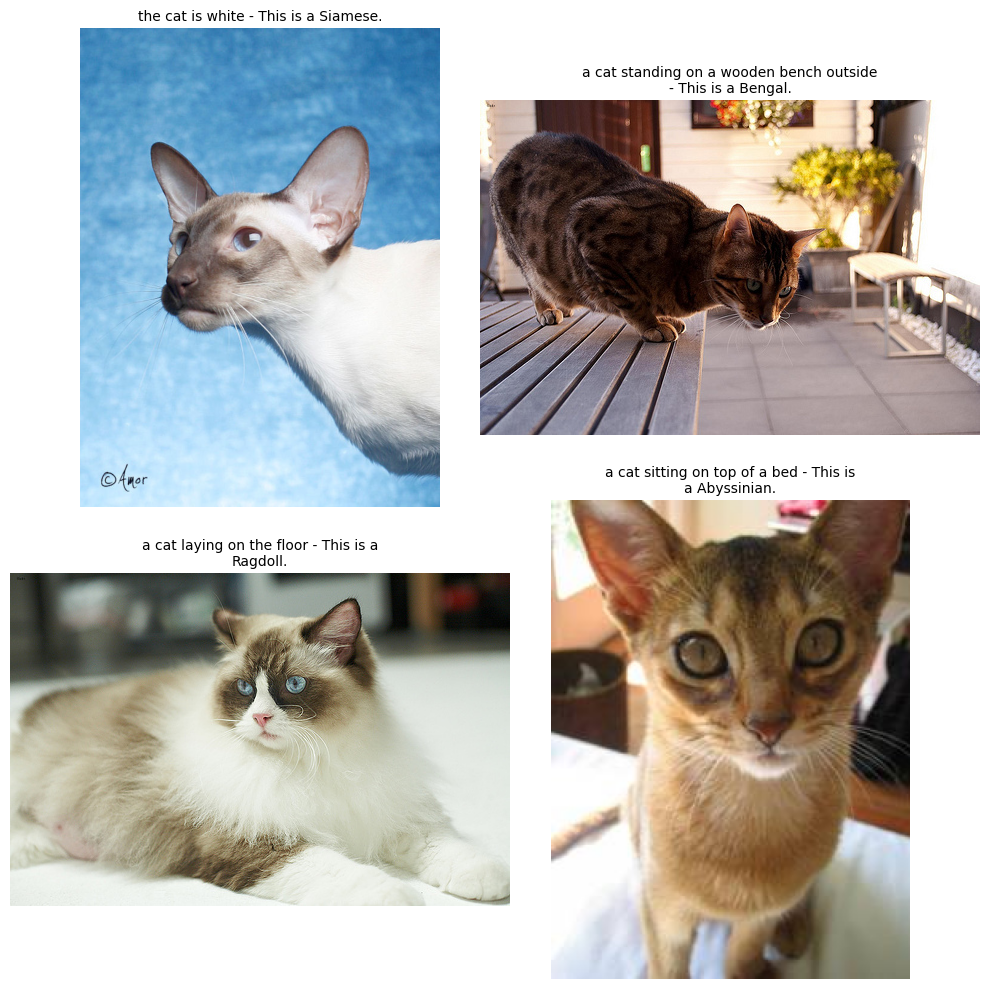

In [22]:
caption_gen.visualize_captions(num_samples=4)

### Print some statistics

In [23]:
print(f"\nTotal captions generated: {len(caption_gen.captions_cache)}")
print("\nSample of generated captions:")
for path, caption in list(caption_gen.captions_cache.items())[:3]:
    print(f"\nImage: {Path(path).name}")
    print(f"Caption: {caption}")


Total captions generated: 7349

Sample of generated captions:

Image: British_Shorthair_130.jpg
Caption: the cat is looking at the camera - This is a British Shorthair.

Image: Abyssinian_100.jpg
Caption: the cat is orange - This is a Abyssinian.

Image: Abyssinian_101.jpg
Caption: a cat with green eyes looking at the camera - This is a Abyssinian.


## Imgae Generation with Conditional GAN

In [2]:
# Setup device

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

Device used: cpu


In [3]:
# Configurations

batch_size = 32
image_size = 128
num_workers = 4

In [4]:
# Setup components

metrics = MetricsTracker([
    FIDScore(device=device),
    CLIPScore(device=device)
])

logger = GANLogger("conditional_gan", log_dir="logs")

callbacks = [
    EarlyStopping(monitor='fid', patience=5),
    ModelCheckpoint(filepath="checkpoints/best.pt", monitor='fid'),
    MetricsHistory(log_dir="logs/metrics")
]

2025-02-27 18:59:34 - INFO - Logger initialized in logs


In [5]:
# Load Dataset

data_dir = Path('./data')
handler = PetDatasetHandler(data_dir)
train_dataset, test_dataset = handler.load_dataset()

In [ ]:
# Load Captions
with open('output/captions/captions_traindataset.json', 'r') as f:
    caption_dict = json.load(f)

In [7]:
train_images_paths = [str(img) for img in train_dataset._images]

val_images_paths = [str(img) for img in test_dataset._images]

In [8]:
# Initialize train and val loader

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_ds = PetDatasetWithCaptions(
    image_paths=train_images_paths, 
    caption_dict=caption_dict,
    transform=transform
)

# TO BE FIXED - I need to split train_dataset in train and validation. This val_dataset should be TEST SET
val_ds = PetDatasetWithCaptions(
    image_paths=val_images_paths,   
    caption_dict=caption_dict,
    transform=transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [10]:
# Initialize GAN model

config = GANConfig(
    latent_dim = 100,
    caption_dim = 768,
    image_size = image_size,
    num_channels = 3,
    generator_features = 64
)

gan = ConditionalGAN(config)

/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/Gen-AI-for-Data-Augmentation/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/Gen-AI-for-Data-Augmentation/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/silvanoquarto/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.6MB/s]


In [11]:
# Initialize trainer

trainer = GANTrainer(
    gan=gan,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    metrics_tracker=metrics,
    logger=logger,
    callbacks=callbacks
)

In [ ]:
# Train

trainer.train(
    num_epochs=1,
    eval_freq=1,
    sample_freq=500,
    sample_dir=Path("samples")
)